In [1]:
# Imports for Qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.visualization import plot_histogram
import qiskit.circuit.library as qulib
from qiskit_aer import AerSimulator

# Various imports
import numpy as np

##IBMQ.save_account('Put your token')
##provider = IBMQ.load_account()
##IBMQ.get_provider(hub='ibm-q', group='open', project = 'main')

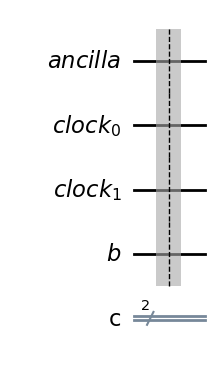

In [2]:
# Create the various registers needed
clock = QuantumRegister(2, name='clock')
input_reg = QuantumRegister(1, name='b')
ancilla = QuantumRegister(1, name='ancilla')
measurement = ClassicalRegister(2, name='c')

# Create an empty circuit with the specified registers
circuit = QuantumCircuit(ancilla, clock, input_reg, measurement)

circuit.barrier()
circuit.draw(output='mpl')

In [3]:
def qft_dagger(circ, q, n):      
    circ.h(clock[1]);
    for j in reversed(range(n)):
      for k in reversed(range(j+1,n)):
        circ.cp(-np.pi/float(2**(k-j)), q[k], q[j]);
        #circ.cu(0,0,0,-np.pi/float(2**(k-j)), q[k], q[j]);
    circ.h(clock[0]);
    circ.swap(clock[0], clock[1]);

def qft(circ, q, n):
    circ.swap(clock[0], clock[1]);
    circ.h(clock[0]);
    for j in reversed(range(n)):
      for k in reversed(range(j+1,n)):
        circ.cp(np.pi/float(2**(k-j)), q[k], q[j]);
        #circ.cu(0,0,0,np.pi/float(2**(k-j)), q[k], q[j]);
    circ.h(clock[1]);

In [4]:
def qpe(circ, clock, target):
    circuit.barrier()
    #U=e^{i*A*t} <--
    circuit.cu(np.pi / 2, -np.pi / 2, np.pi / 2, 3 * np.pi / 4, clock[0], input_reg, label='U');
    
    # U^2=e^{i*A*t*2} <--
    circuit.cu(np.pi, np.pi, 0, 0, clock[1], input_reg, label='U2');

    circuit.barrier();
    
    # Perform an inverse QFT on the register holding the eigenvalues
    qft_dagger(circuit, clock, 2)
    
def inv_qpe(circ, clock, target):
    
    # Perform a QFT on the register holding the eigenvalues
    qft(circuit, clock, 2)

    circuit.barrier()

    # U^-2=e^{i*A*t*2} <--
    circuit.cu(np.pi, np.pi, 0, 0, clock[1], input_reg, label='U2');

    #circuit.barrier();

    # U^-1=e^{i*A*t} <--
    circuit.cu(np.pi / 2, np.pi / 2, -np.pi / 2, -3 * np.pi / 4, clock[0], input_reg, label='U');

    circuit.barrier()

In [5]:
def hhl(circ, ancilla, clock, input, measurement):
    
    qpe(circ, clock, input)

    circuit.barrier()
    
    # This section is to test and implement  <--
    #circuit.cry(np.pi, clock[0], ancilla)
    #circuit.cry(np.pi/3, clock[1], ancilla)
    ccRy1=qulib.RYGate(np.pi).control(2, ctrl_state='01')
    circuit.append(ccRy1,[clock[0],clock[1],ancilla])
    ccRy2=qulib.RYGate(np.pi/3).control(2, ctrl_state='10')
    circuit.append(ccRy2,[clock[0],clock[1],ancilla])
    circuit.barrier()
    
    circuit.measure(ancilla, measurement[0])
    circuit.barrier()
    inv_qpe(circ, clock, input)

In [6]:
# State preparation. 
intial_state = [0,1]
circuit.initialize(intial_state, 3)

circuit.barrier()

# Perform a Hadamard Transform
circuit.h(clock)

hhl(circuit, ancilla, clock, input_reg, measurement)

# Perform a Hadamard Transform
circuit.h(clock)

circuit.barrier()


#circuit.measure(input, measurement[1])

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=4, num_clbits=0, params=[]), qubits=(<Qubit register=(1, "ancilla"), index=0>, <Qubit register=(2, "clock"), index=0>, <Qubit register=(2, "clock"), index=1>, <Qubit register=(1, "b"), index=0>), clbits=())

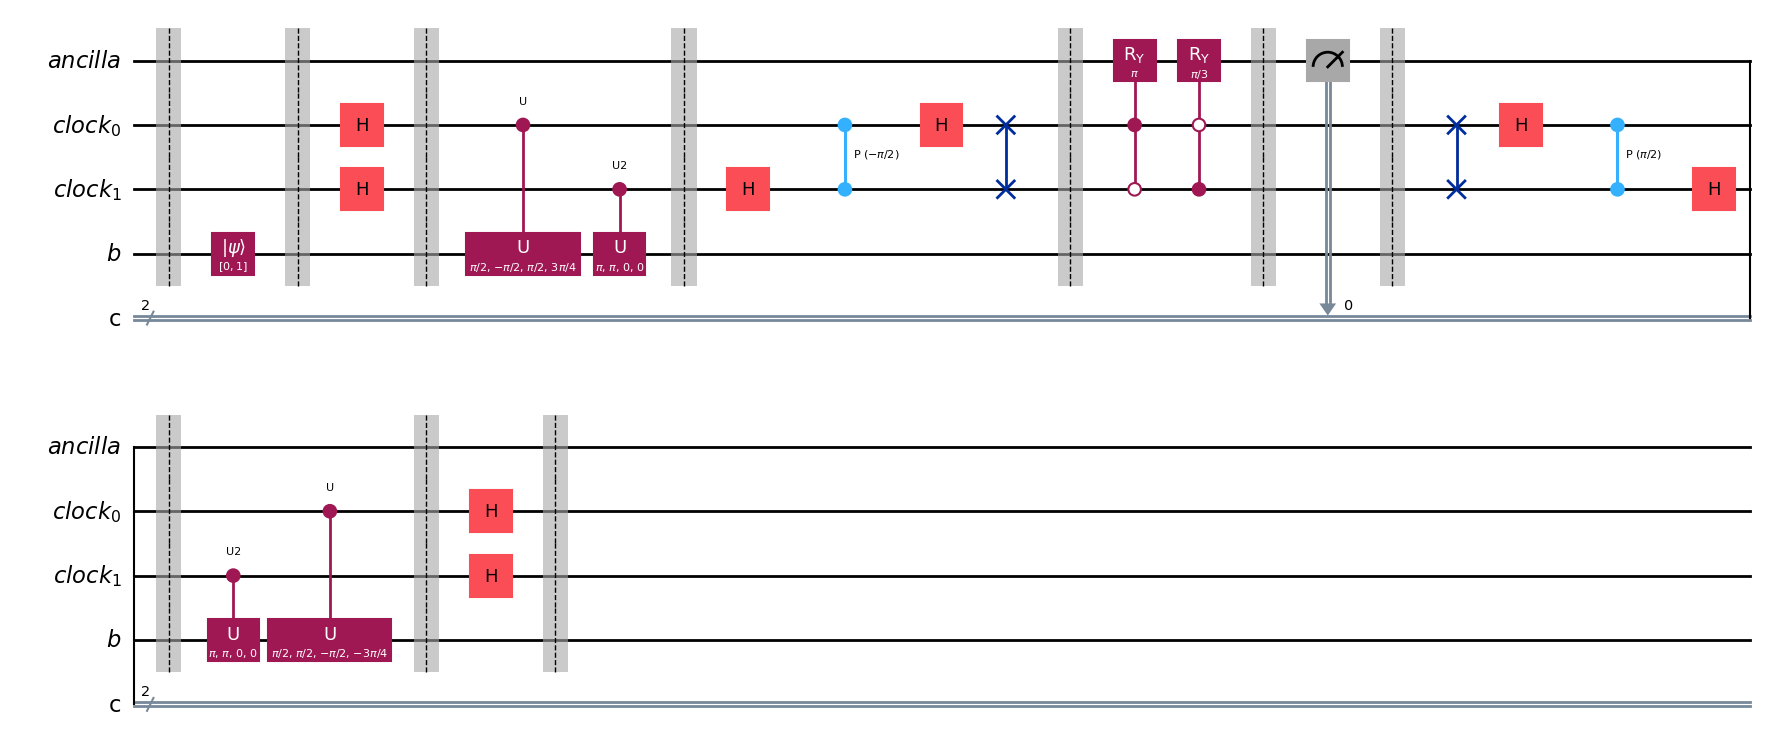

In [7]:
circuit.draw('mpl',scale=1)

In [8]:
simulator = AerSimulator()

transpiled_circuit = transpile(circuit, simulator)

shots = 10000
job = simulator.run(transpiled_circuit, shots=shots)
result = job.result()

counts = result.get_counts()
print(counts)

{'01': 6225, '00': 3775}


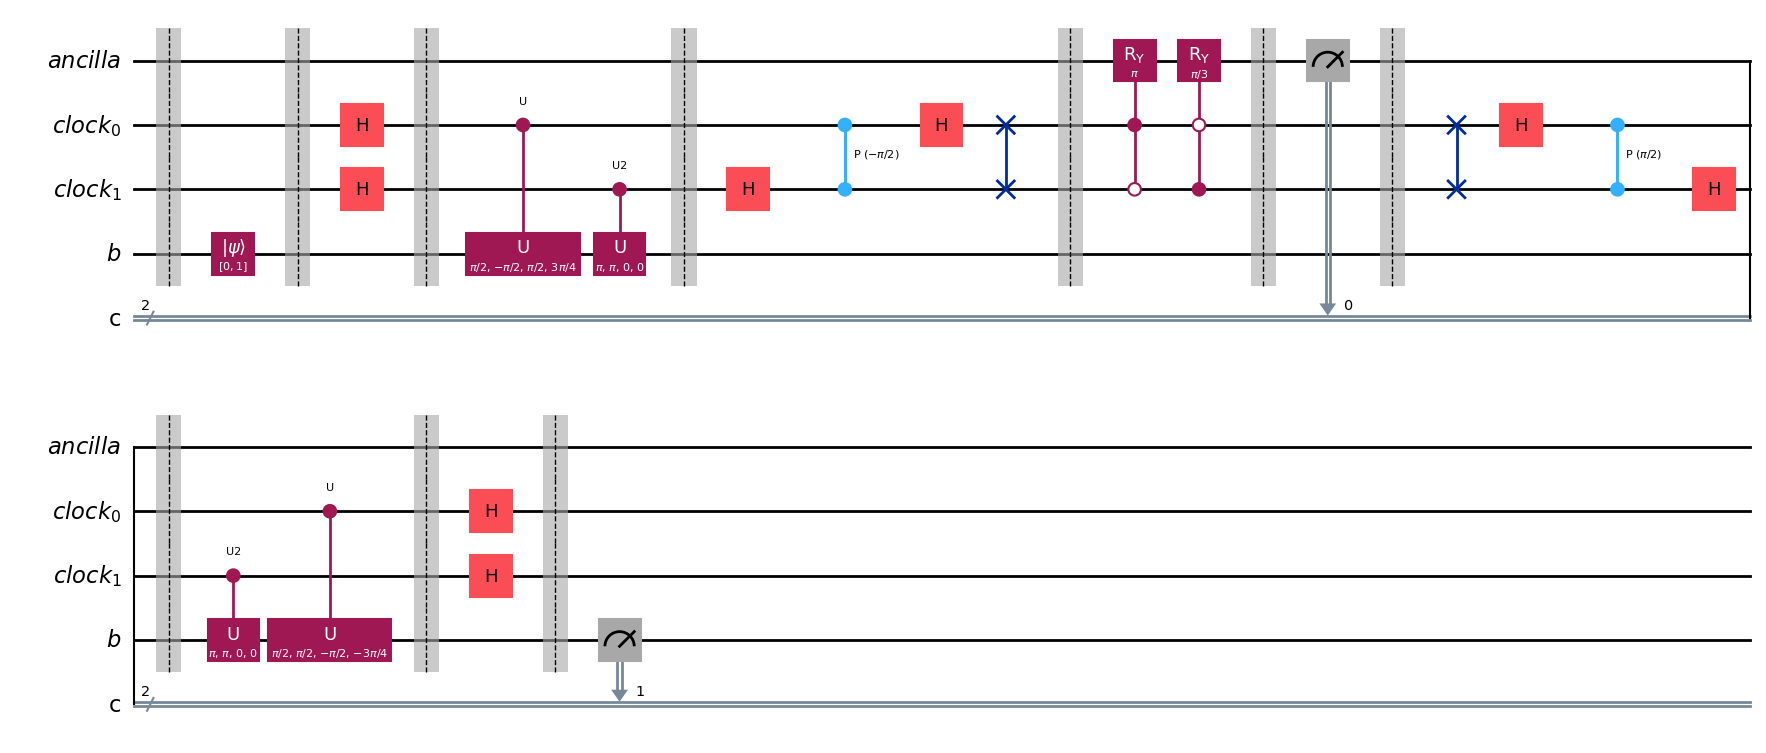

In [9]:
circuit.measure(input_reg, measurement[1])
circuit.draw('mpl',scale=1)

In [10]:
print(counts)

{'01': 6225, '00': 3775}


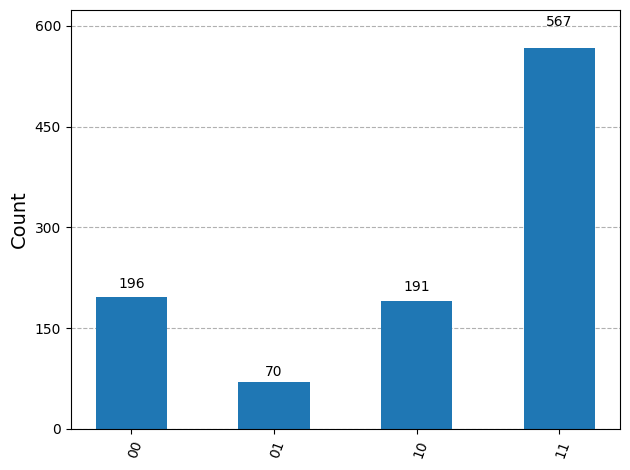

In [11]:
probe=1024
#65536
# Execute the circuit using the simulator
simulator = AerSimulator()

transpiled_circuit = transpile(circuit, simulator)
job = simulator.run(transpiled_circuit, shots=probe)

#Get the result of the execution
result = job.result()

# Get the counts, the frequency of each answer
counts = result.get_counts()

# Display the results
plot_histogram(counts)

In [12]:
print(counts)

{'11': 567, '00': 196, '10': 191, '01': 70}


In [13]:
67/593

0.11298482293423272

In [14]:
1/9

0.1111111111111111

In [15]:
2*np.arcsin(1/3)

np.float64(0.6796738189082439)

In [16]:
np.rad2deg(0.6796738189082439)

np.float64(38.94244126898138)

In [17]:
38.94244126898138/180

0.21634689593878548